In [ ]:
import pandas as pd
from matplotlib.pyplot import *
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder

[[-1.87  -0.228]
 [-0.923 -0.228]
 [-0.923 -0.228]
 ...
 [-1.87  -0.228]
 [ 0.965 -0.228]
 [-0.923 -0.228]]
     pcost       dcost       gap    pres   dres
 0: -1.4749e+03 -3.8857e+03  2e+03  3e-13  3e+00
 1: -2.9220e+03 -2.9716e+03  5e+01  4e-13  1e+00
 2: -1.7609e+05 -1.7612e+05  3e+01  3e-11  1e+00
 3: -9.9522e+08 -9.9522e+08  2e+03  3e-08  1e+00
 4: -1.7567e+10 -1.7567e+10  4e+04  2e-06  1e+00
Terminated (singular KKT matrix).
1870 support vectors out of 1870 points
214 out of 331 predictions correct
Accuracy of Model is : 
64.6525679758308


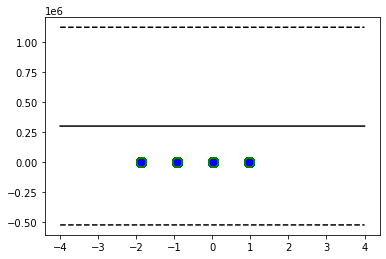

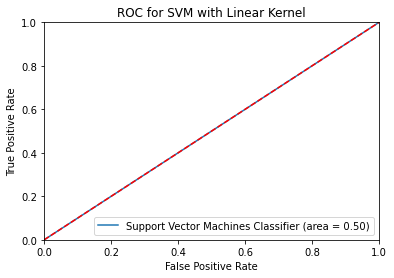

     pcost       dcost       gap    pres   dres
 0: -1.4186e+03 -3.6299e+03  6e+03  4e+01  3e+00
 1: -5.6782e+03 -7.2441e+03  2e+03  2e+01  1e+00
 2: -2.4999e+04 -2.7102e+04  2e+03  2e+01  1e+00
 3: -2.5616e+05 -2.6243e+05  6e+03  2e+01  1e+00
 4: -9.6036e+06 -9.6339e+06  3e+04  2e+01  1e+00
 5: -2.7997e+09 -2.8005e+09  8e+05  2e+01  1e+00
 6: -3.6849e+09 -3.6859e+09  1e+06  2e+01  1e+00
Terminated (singular KKT matrix).
1867 support vectors out of 1870 points
216 out of 331 predictions correct
65.25679758308158


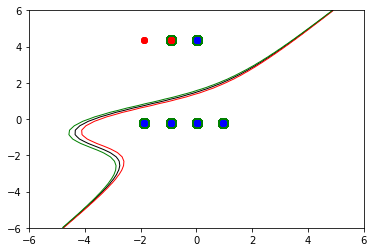

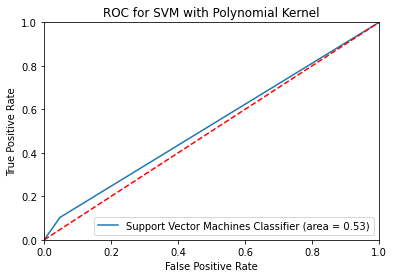

     pcost       dcost       gap    pres   dres
 0: -5.6169e+05 -2.7024e+08  3e+08  6e-11  1e-10
 1: -6.4909e+05 -3.6609e+06  3e+06  8e-11  2e-10
 2: -7.1575e+05 -9.6355e+05  2e+05  5e-12  4e-11
 3: -8.3672e+05 -8.4771e+05  1e+04  1e-11  4e-11
 4: -8.4005e+05 -8.4016e+05  1e+02  7e-11  4e-11
 5: -8.4008e+05 -8.4009e+05  1e+00  5e-11  5e-11
 6: -8.4008e+05 -8.4008e+05  1e-02  9e-13  6e-11
Optimal solution found.
1870 support vectors out of 1870 points
258 out of 331 predictions correct
77.94561933534743


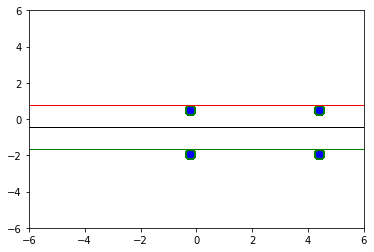

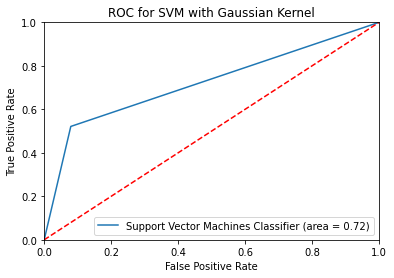

In [ ]:
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers
             
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

class SVM(object):

    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print("%d support vectors out of %d points" % (len(self.a), n_samples))

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)

        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

if __name__ == "__main__":
    import pylab as pl

    def plot_margin(X1_train, X2_train, clf):
        def f(x, w, b, c=0):
            return (-w[0] * x - b + c) / w[1]

        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

    
        a0 = -4; a1 = f(a0, clf.w, clf.b)
        b0 = 4; b1 = f(b0, clf.w, clf.b)
        pl.plot([a0,b0], [a1,b1], "k")

    
        a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
        pl.plot([a0,b0], [a1,b1], "k--")

        
        a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
        pl.plot([a0,b0], [a1,b1], "k--")

        pl.axis("tight")
        pl.show()
        
        
    def accuracy_metric(actual, predicted):
      correct = 0
      for i in range(len(actual)):
        if actual[i] == predicted[i]:
          correct += 1
      return correct / float(len(actual)) * 100.0

    def plot_contour(X1_train, X2_train, clf):
        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

        X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
        X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Z = clf.project(X).reshape(X1.shape)
        pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z + 1, [0.0], colors='red', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z - 1, [0.0], colors='green', linewidths=1, origin='lower')

        pl.axis("tight")
        pl.show()

    def test_linear():

        dataset = pd.read_csv("https://raw.githubusercontent.com/psantul/Dataset/main/titanic.csv",delimiter = ',', encoding='latin-1')
        
        x = dataset.iloc[:,0:2].values
        y = dataset.iloc[:,-1].values
        print(x)

        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(x,y,test_size = 0.15, random_state=1)          

        clf = SVM()
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        #print(y_predict)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))
        accuracy = accuracy_metric(y_test, y_predict)
        print("Accuracy of Model is : ")
        print(accuracy)

        plot_margin(X_train[y_train==1], X_train[y_train==-1], clf)


        roc_auc4 = roc_auc_score(y_test, y_predict)
        fpr4, tpr4, thresholds4 = roc_curve(y_test, y_predict)
        plt.figure()
        plt.plot(fpr4, tpr4, label='Support Vector Machines Classifier (area = %0.2f)' % roc_auc4)
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC for SVM with Linear Kernel')
        plt.legend(loc="lower right")
        plt.savefig('Log_ROC_SVM')
        plt.show()

       
        

    def test_non_linear():

        dataset = pd.read_csv("https://raw.githubusercontent.com/psantul/Dataset/main/titanic.csv",delimiter = ',', encoding='latin-1')
        
        x = dataset.iloc[:,0:2].values
        y = dataset.iloc[:,-1].values

        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(x,y,test_size = 0.15, random_state=1)

        clf = SVM(polynomial_kernel)
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        #print(y_predict)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))

        accuracy = accuracy_metric(y_test, y_predict)
        print(accuracy)

        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)


        roc_auc4 = roc_auc_score(y_test, y_predict)
        fpr4, tpr4, thresholds4 = roc_curve(y_test, y_predict)
        plt.figure()
        plt.plot(fpr4, tpr4, label='Support Vector Machines Classifier (area = %0.2f)' % roc_auc4)
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC for SVM with Polynomial Kernel')
        plt.legend(loc="lower right")
        plt.savefig('Log_ROC_SVM')
        plt.show()
        

    def test_soft():

        dataset = pd.read_csv("https://raw.githubusercontent.com/psantul/Dataset/main/titanic.csv",delimiter = ',', encoding='latin-1')
        
        x = dataset.iloc[:,1:3].values
        y = dataset.iloc[:,-1].values

        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(x,y,test_size = 0.15, random_state=1)

        clf = SVM(C=1000.1)
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        #print(y_predict)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))
        #print("Accuracy: %.3f (%.3f)" % (y_test.mean(), y_predict.std()))
        accuracy = accuracy_metric(y_test, y_predict)
        print(accuracy)

        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)
        
        roc_auc4 = roc_auc_score(y_test, y_predict)
        fpr4, tpr4, thresholds4 = roc_curve(y_test, y_predict)
        plt.figure()
        plt.plot(fpr4, tpr4, label='Support Vector Machines Classifier (area = %0.2f)' % roc_auc4)
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC for SVM with Gaussian Kernel')
        plt.legend(loc="lower right")
        plt.savefig('Log_ROC_SVM')
        plt.show()

        
    test_linear()
    test_non_linear()
    test_soft()